In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


/tmp/ipykernel_3042081/1438410382.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)


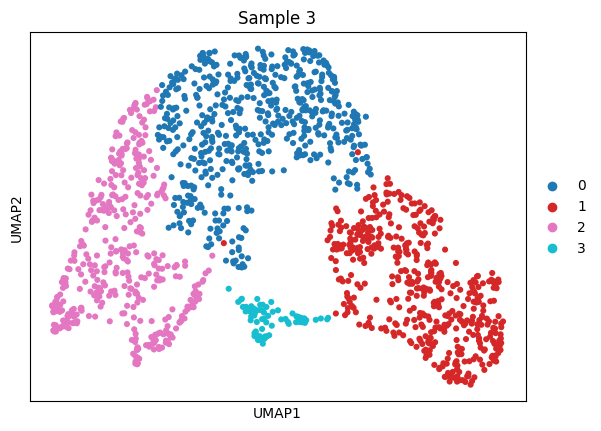

In [5]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


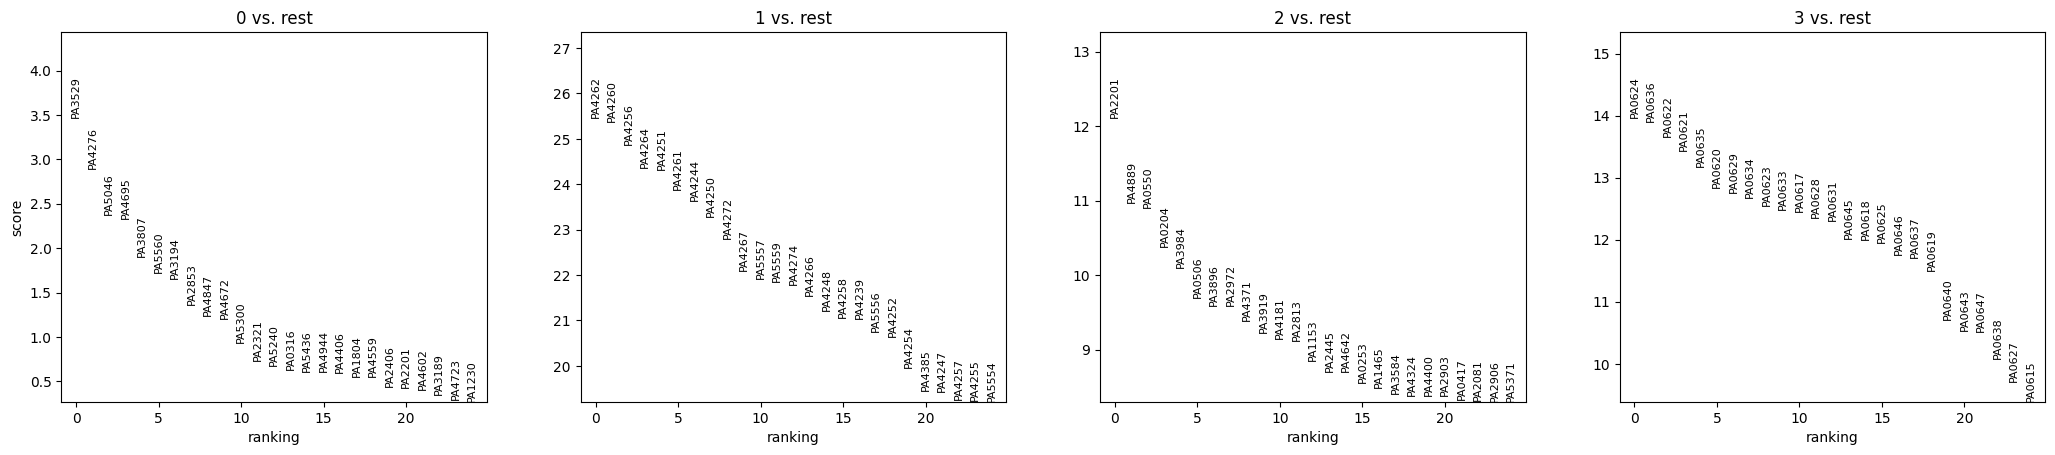

In [6]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [7]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

KeyboardInterrupt: 

## Find optimal correlation matrix scaling and generate synthetic null data

In [225]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

KeyboardInterrupt: 

In [ ]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.2360679772046799

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [ ]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [ ]:
data_gene.obs

In [ ]:
data_null_gen.layers["counts"] = data_null_gen.X.copy()
data_null_gen.var["var_counts_unscaled"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts_unscaled"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["total_counts_unscaled"] = np.asarray(np.sum(data_null_gen.X, axis=0)).squeeze()

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen.X = np.ceil(data_null_gen.X / (data_null_gen.obs["total_counts"].values)[:, np.newaxis] * (data_gene.obs["total_counts"].values)[:, np.newaxis])
data_null_gen.layers["scaled_counts"] = data_null_gen.X.copy()


In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [ ]:
data_null_gen.obs

In [ ]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

In [ ]:
cor_orig = spearmanr(data_gene_nonzero.layers["counts"].toarray()).statistic
cor_orig = pd.DataFrame(cor_orig, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen = spearmanr(data_null_gen.X).statistic
cor_gen = pd.DataFrame(cor_gen, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})
all_cors["ratio"] = all_cors["cor_orig"]/all_cors["cor_gen"]

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### Process null data

In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts_scaled"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts_scaled"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [ ]:
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", layer="counts")
for val in ["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct"]:
    data_null_gen.var[f"{val}_unscaled"] = data_null_gen.var[val]

In [ ]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


In [ ]:
data_null_gen.var

In [ ]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [ ]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

In [ ]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [ ]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [ ]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [ ]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

In [ ]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

In [ ]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [ ]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

In [ ]:
pvals_log_gen["1"]

In [ ]:
pvals_log_gen["0"]

In [ ]:
# goi = pvals_log_gen["3"].sort_values("pval_null", ascending=True).index[:10]
goi = ['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252',
       'PA4274', 'PA4250', 'PA5556']
print(goi)

sc.pl.umap(data_null_gen, color=goi, cmap="viridis")

## Testing...

In [291]:
nb_est_df_unscaled = ((data_null_gen.var.reset_index()[["nb_mean_unscaled", "nb_overdisp_unscaled", "nb_overdisp_cutoff_unscaled", "mean_counts_unscaled", "var_counts_unscaled", "PAO1_ID", "nb_umi_unscaled", "Intercept_step1_sct_unscaled", "log_umi_step1_sct_unscaled", "dispersion_step1_sct_unscaled", "total_counts_unscaled"]]))
nb_est_df_unscaled.columns = ["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]
nb_est_df_unscaled["type"] = "null_unscaled"

nb_est_df_null = data_null_gen.var.reset_index()[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_null["type"] = "null_scaled"

nb_est_df_gene = data_gene.var[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_gene["type"] = "real"

nb_est_df = pd.concat([nb_est_df_null, nb_est_df_gene, nb_est_df_unscaled]).reset_index()
nb_est_df

,index,nb_mean,nb_overdisp,nb_overdisp_cutoff,mean_counts,var_counts,n_cells_by_counts,PAO1_ID,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,total_counts,type
0,0,-7.613363,1.378310,1.378310,0.885363,2.418853,729.0,PA0001,2.338451,NaN,NaN,NaN,1367.0,null_scaled
1,1,-7.862312,0.864735,0.864735,0.598446,1.363365,555.0,PA0002,2.304435,NaN,NaN,NaN,924.0,null_scaled
2,2,-7.461064,1.693212,1.693212,1.038860,2.243309,832.0,PA0003,2.351761,NaN,NaN,NaN,1604.0,null_scaled
3,3,-7.950617,0.674156,0.674156,0.495466,1.033658,478.0,PA0004,2.277526,-8.085530,2.310471,0.132639,765.0,null_scaled
4,4,-8.421236,0.203886,0.203886,0.212435,0.461348,203.0,PA0005,2.158279,-9.356543,2.440548,0.185531,328.0,null_scaled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16640,5541,-5.812312,0.103445,0.103445,0.012306,0.013450,NaN,PA5566,0.451529,-6.783261,0.776778,0.027348,19.0,null_unscaled
16641,5542,-7.116011,0.851984,0.851984,0.147668,0.197106,NaN,PA5567,1.671022,-7.806692,1.902440,0.083684,228.0,null_unscaled
16642,5543,-8.549095,5.568968,5.568968,0.642487,0.703791,NaN,PA5568,2.614929,NaN,NaN,NaN,992.0,null_unscaled
16643,5544,-7.624991,3.579093,3.579093,3.599741,12.061295,NaN,PA5569,2.859447,-8.971970,3.277005,0.115653,5558.0,null_unscaled


In [296]:
nb_est_df["nb_est"] = np.exp(nb_est_df["Intercept_step1_sct"] + nb_est_df["log_umi_step1_sct"] * np.log10(nb_est_df["total_counts"]))
nb_est_df["nb_est_smoothed"] = np.exp(nb_est_df["nb_mean"] + nb_est_df["nb_umi"] * np.log10(nb_est_df["total_counts"]))


[None, None]

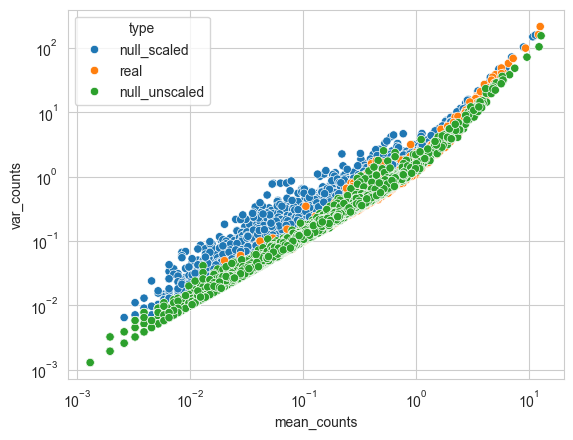

In [322]:
g = sns.scatterplot(nb_est_df, x="mean_counts", y="var_counts", hue="type")
g.set(xscale="log", yscale="log")

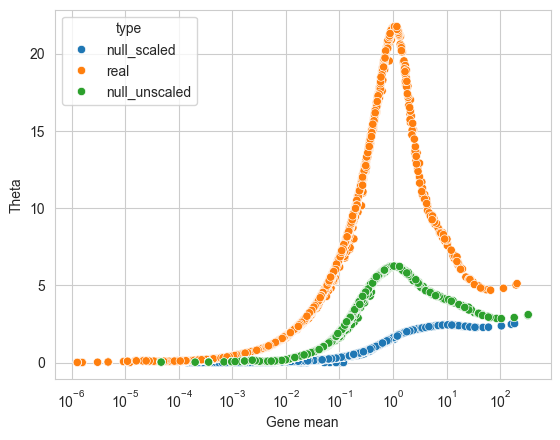

In [300]:
g = sns.scatterplot(data=nb_est_df, y="nb_overdisp_cutoff", x="nb_est_smoothed", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

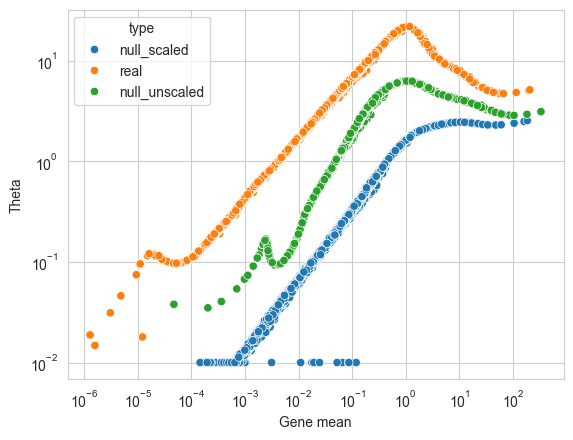

In [301]:
g = sns.scatterplot(data=nb_est_df, y="nb_overdisp_cutoff", x="nb_est_smoothed", hue="type")
g.set(xscale="log", yscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

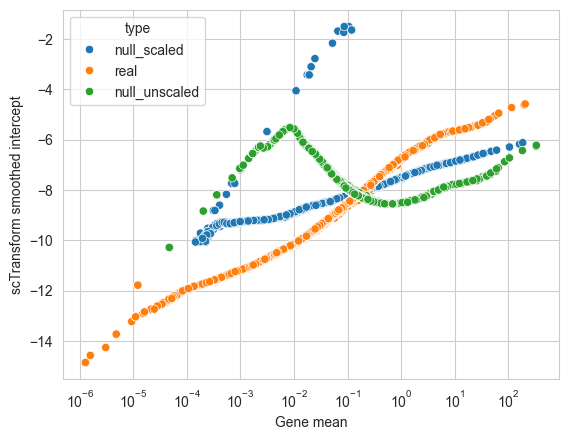

In [303]:
g = sns.scatterplot(data=nb_est_df, y="nb_mean", x="nb_est_smoothed", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed intercept")
plt.show()

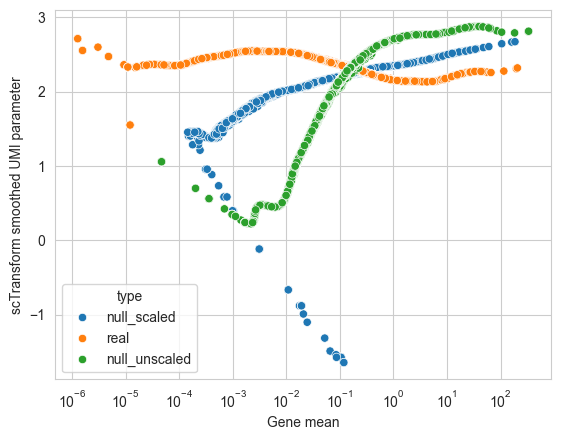

In [304]:
g = sns.scatterplot(data=nb_est_df, y="nb_umi", x="nb_est_smoothed", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed UMI parameter")
plt.show()

In [318]:
nb_est_df[(nb_est_df["nb_umi"] < 1) & (nb_est_df["type"] == "null_scaled")]

,index,nb_mean,nb_overdisp,nb_overdisp_cutoff,mean_counts,var_counts,n_cells_by_counts,PAO1_ID,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,total_counts,type,nb_est_real,nb_est_smoothed,nb_est
51,51,-1.635475,-0.141630,0.01,0.001295,0.001294,2.0,PA0050,-1.643960,6.876124,-4.412363,0.005606,2.0,null_scaled,5.547870,0.118795,2.566902e+02
437,437,-1.498209,0.005746,0.01,0.001943,0.001939,3.0,PA0439,-1.573718,3.771408,-3.249618,0.005148,3.0,null_scaled,2.220946,0.105498,9.216047e+00
564,564,-8.813436,0.003238,0.01,0.004534,0.009694,4.0,PA0567,0.957111,-14.737369,2.908388,0.246482,7.0,null_scaled,-12.279495,0.000334,4.646040e-06
680,680,-8.813436,0.003238,0.01,0.003886,0.005166,5.0,PA0685,0.957111,-13.916048,2.611292,0.080544,6.0,null_scaled,-11.884068,0.000313,6.899456e-06
732,732,-8.813436,0.003238,0.01,0.003886,0.005166,5.0,PA0736a,0.957111,-14.111000,2.670795,0.067359,6.0,null_scaled,-12.032718,0.000313,5.946441e-06
840,840,-1.498209,0.005746,0.01,0.001943,0.001939,3.0,PA0845,-1.573718,-2.522314,-1.194123,0.006016,3.0,null_scaled,-3.092055,0.105498,4.540852e-02
1207,1207,-7.193213,0.003188,0.01,0.003886,0.007757,4.0,PA1213,0.398092,-14.275632,2.720995,0.177236,6.0,null_scaled,-12.158286,0.001025,5.244732e-06
1231,1231,-1.498209,0.005746,0.01,0.001943,0.001939,3.0,PA1237,-1.573718,-3.162927,-0.987317,0.006195,3.0,null_scaled,-3.633997,0.105498,2.641041e-02
1486,1486,-7.736513,0.003187,0.01,0.003886,0.006462,4.0,PA1491,0.583769,-4.290811,-0.402197,0.224905,6.0,null_scaled,-4.603781,0.000688,1.001390e-02
1887,1887,-5.675516,0.003252,0.01,0.003238,0.004523,4.0,PA1888,-0.116719,-15.238602,2.958412,0.080517,5.0,null_scaled,-13.170761,0.003160,1.905510e-06


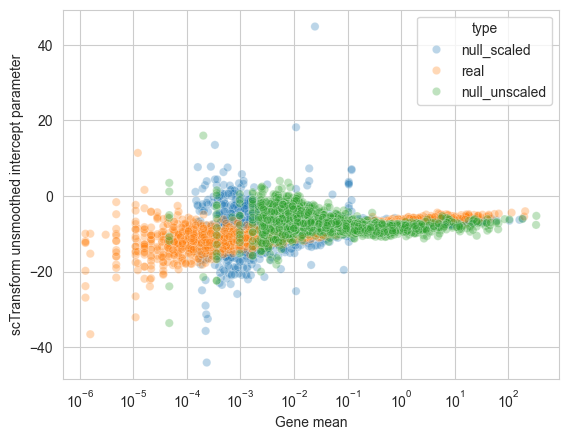

In [305]:
g = sns.scatterplot(data=nb_est_df, y="Intercept_step1_sct", x="nb_est_smoothed", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed intercept parameter")
plt.show()

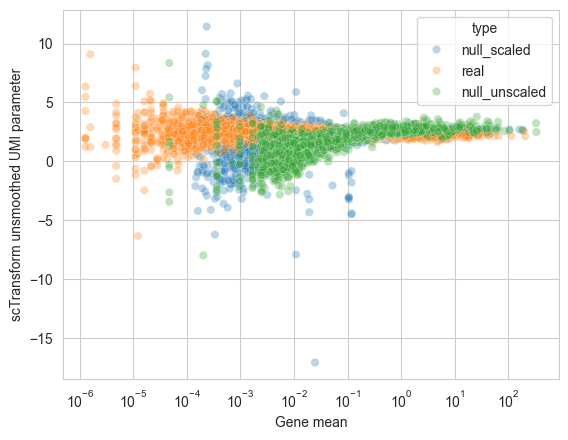

In [306]:
g = sns.scatterplot(data=nb_est_df, y="log_umi_step1_sct", x="nb_est_smoothed", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed UMI parameter")
plt.show()

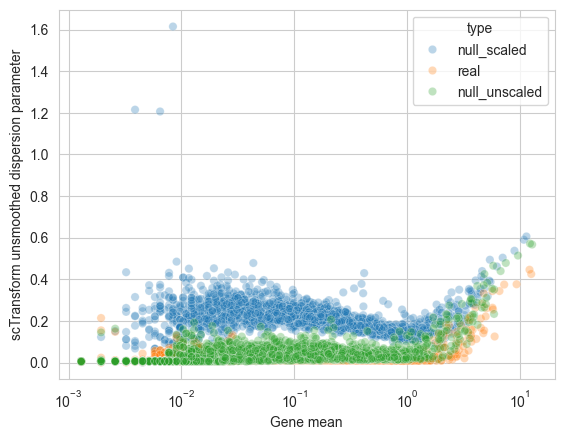

In [319]:
g = sns.scatterplot(data=nb_est_df, y="dispersion_step1_sct", x="mean_counts", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed dispersion parameter")
plt.show()

In [282]:
nb_est_df_paired = nb_est_df.pivot(index="PAO1_ID", columns="type")
nb_est_df_paired.columns = ['_'.join(col).strip() for col in nb_est_df_paired.columns.values]
nb_est_df_paired

,index_null_scaled,index_null_unscaled,index_real,nb_mean_null_scaled,nb_mean_null_unscaled,nb_mean_real,nb_overdisp_null_scaled,nb_overdisp_null_unscaled,nb_overdisp_real,nb_overdisp_cutoff_null_scaled,...,Intercept_step1_sct_real,log_umi_step1_sct_null_scaled,log_umi_step1_sct_null_unscaled,log_umi_step1_sct_real,dispersion_step1_sct_null_scaled,dispersion_step1_sct_null_unscaled,dispersion_step1_sct_real,total_counts_null_scaled,total_counts_null_unscaled,total_counts_real
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,0,0,PA0001,-7.613363,-8.555143,-7.104036,1.378310,5.839926,18.563001,1.378310,...,-6.941972,NaN,NaN,2.135988,NaN,NaN,0.009296,1367.0,1100.0,1029.0
PA0002,1,1,PA0002,-7.862312,-8.461460,-7.709383,0.864735,4.517145,12.341271,0.864735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924.0,809.0,724.0
PA0003,2,2,PA0003,-7.461064,-8.509668,-6.669634,1.693212,6.254566,21.748395,1.693212,...,-6.444100,NaN,2.871205,2.071128,NaN,0.015666,0.008896,1604.0,1410.0,1380.0
PA0004,3,3,PA0004,-7.950617,-8.314597,-8.051578,0.674156,3.400807,9.686403,0.674156,...,-8.528122,2.310471,2.885378,2.453933,0.132639,0.018295,0.009515,765.0,619.0,577.0
PA0005,4,4,PA0005,-8.421236,-7.145612,-9.842994,0.203886,0.871806,2.331796,0.203886,...,NaN,2.440548,NaN,NaN,0.185531,NaN,NaN,328.0,218.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,5541,5541,PA5566,-9.257338,-5.812312,-11.919682,0.013268,0.103445,0.112193,0.013268,...,NaN,NaN,0.776778,NaN,NaN,0.027348,NaN,27.0,19.0,15.0
PA5567,5542,5542,PA5567,-8.462275,-7.116011,-9.835550,0.184945,0.851984,2.347852,0.184945,...,-9.934617,2.940720,1.902440,2.556388,0.235617,0.083684,0.029657,333.0,228.0,196.0
PA5568,5543,5543,PA5568,-7.665811,-8.549095,-7.111111,1.273077,5.568968,18.485174,1.273077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1232.0,992.0,1019.0


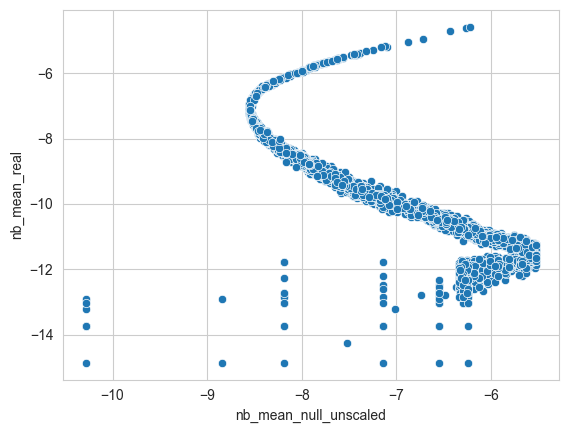

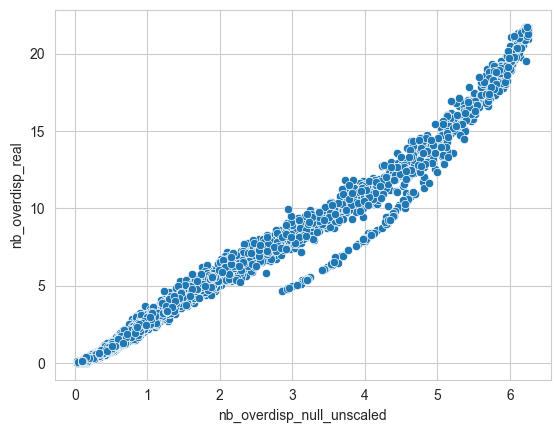

In [283]:
sns.scatterplot(nb_est_df_paired, x="nb_mean_null_unscaled", y="nb_mean_real")
plt.show()

sns.scatterplot(nb_est_df_paired, x="nb_overdisp_null_unscaled", y="nb_overdisp_real")
plt.show()

In [284]:
nb_est_df_paired["nb_est_real"] = nb_est_df_paired["Intercept_step1_sct_real"] + nb_est_df_paired["log_umi_step1_sct_real"] * np.log10(nb_est_df_paired["total_counts_real"])
nb_est_df_paired["nb_est_null_scaled"] = nb_est_df_paired["Intercept_step1_sct_null_scaled"] + nb_est_df_paired["log_umi_step1_sct_null_scaled"] * np.log10(nb_est_df_paired["total_counts_null_scaled"])
nb_est_df_paired["nb_est_null_unscaled"] = nb_est_df_paired["Intercept_step1_sct_null_unscaled"] + nb_est_df_paired["log_umi_step1_sct_null_unscaled"] * np.log10(nb_est_df_paired["total_counts_null_unscaled"])

nb_est_df_paired["nb_est_real_smoothed"] = nb_est_df_paired["nb_mean_real"] + nb_est_df_paired["nb_umi_real"] * np.log10(nb_est_df_paired["total_counts_real"])
nb_est_df_paired["nb_est_null_scaled_smoothed"] = nb_est_df_paired["nb_mean_null_scaled"] + nb_est_df_paired["nb_umi_null_scaled"] * np.log10(nb_est_df_paired["total_counts_null_scaled"])
nb_est_df_paired["nb_est_null_unscaled_smoothed"] = nb_est_df_paired["nb_mean_null_unscaled"] + nb_est_df_paired["nb_umi_null_unscaled"] * np.log10(nb_est_df_paired["total_counts_null_unscaled"])

nb_est_df_paired

,index_null_scaled,index_null_unscaled,index_real,nb_mean_null_scaled,nb_mean_null_unscaled,nb_mean_real,nb_overdisp_null_scaled,nb_overdisp_null_unscaled,nb_overdisp_real,nb_overdisp_cutoff_null_scaled,...,dispersion_step1_sct_real,total_counts_null_scaled,total_counts_null_unscaled,total_counts_real,nb_est_real,nb_est_null_scaled,nb_est_null_unscaled,nb_est_real_smoothed,nb_est_null_scaled_smoothed,nb_est_null_unscaled_smoothed
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,0,0,PA0001,-7.613363,-8.555143,-7.104036,1.378310,5.839926,18.563001,1.378310,...,0.009296,1367.0,1100.0,1029.0,-0.507489,NaN,NaN,-0.501984,-0.280523,-0.513995
PA0002,1,1,PA0002,-7.862312,-8.461460,-7.709383,0.864735,4.517145,12.341271,0.864735,...,NaN,924.0,809.0,724.0,NaN,NaN,NaN,-1.237864,-1.028113,-1.177808
PA0003,2,2,PA0003,-7.461064,-8.509668,-6.669634,1.693212,6.254566,21.748395,1.693212,...,0.008896,1604.0,1410.0,1380.0,0.058992,NaN,-0.006673,0.079284,0.076809,0.017231
PA0004,3,3,PA0004,-7.950617,-8.314597,-8.051578,0.674156,3.400807,9.686403,0.674156,...,0.009515,765.0,619.0,577.0,-1.752383,-1.422913,-1.861999,-1.683982,-1.383003,-1.660640
PA0005,4,4,PA0005,-8.421236,-7.145612,-9.842994,0.203886,0.871806,2.331796,0.203886,...,NaN,328.0,218.0,186.0,NaN,-3.216431,NaN,-4.132577,-2.991278,-3.198685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,5541,5541,PA5566,-9.257338,-5.812312,-11.919682,0.013268,0.103445,0.112193,0.013268,...,NaN,27.0,19.0,15.0,NaN,NaN,-5.789953,-9.145974,-6.917799,-5.234919
PA5567,5542,5542,PA5567,-8.462275,-7.116011,-9.835550,0.184945,0.851984,2.347852,0.184945,...,0.029657,333.0,228.0,196.0,-4.074722,-3.563807,-3.320861,-4.069487,-3.045499,-3.175850
PA5568,5543,5543,PA5568,-7.665811,-8.549095,-7.111111,1.273077,5.568968,18.485174,1.273077,...,NaN,1232.0,992.0,1019.0,NaN,NaN,NaN,-0.515954,-0.451880,-0.713430


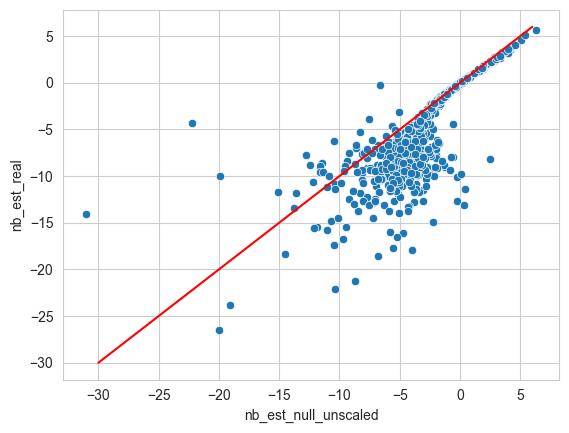

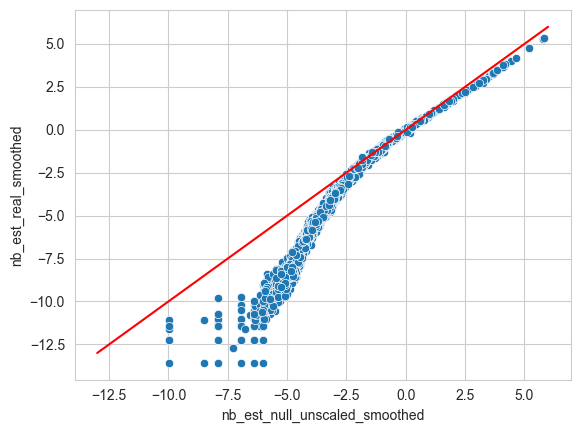

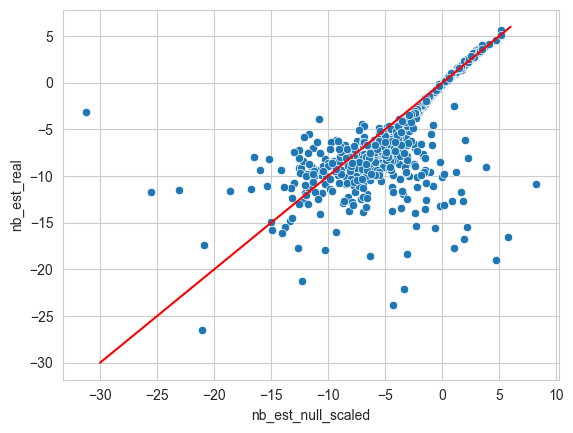

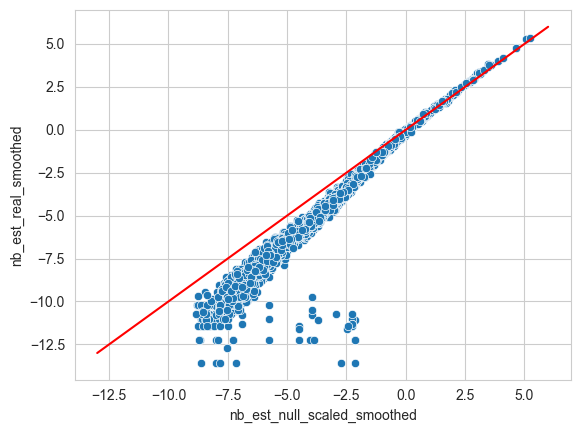

In [285]:
g = sns.scatterplot(nb_est_df_paired, x="nb_est_null_unscaled", y="nb_est_real")
g.plot([-30, 6], [-30, 6], color="red")

plt.show()

g = sns.scatterplot(nb_est_df_paired, x="nb_est_null_unscaled_smoothed", y="nb_est_real_smoothed")
g.plot([-13, 6], [-13, 6], color="red")
plt.show()

g = sns.scatterplot(nb_est_df_paired, x="nb_est_null_scaled", y="nb_est_real")
g.plot([-30, 6], [-30, 6], color="red")

plt.show()

g = sns.scatterplot(nb_est_df_paired, x="nb_est_null_scaled_smoothed", y="nb_est_real_smoothed")
g.plot([-13, 6], [-13, 6], color="red")
plt.show()

In [286]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,leiden
AAACCCAGTGGACCTC-1,1259,7.138867,1379.0,7.229839,1
AAACCCATCCTGTAGA-1,1493,7.309212,1744.0,7.464510,1
AAACGCTCAGATTTCG-1,526,6.267201,783.0,6.664409,0
AAACGCTTCTTTGCTA-1,545,6.302619,1375.0,7.226936,0
AAAGAACCAGTCTGGC-1,932,6.838405,1428.0,7.264730,1
...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,1014,6.922644,1493.0,7.309212,1
TTTGGAGCACCGAATT-1,709,6.565265,5508.0,8.614138,1
TTTGGAGCAGCAGTTT-1,443,6.095825,1002.0,6.910751,0
TTTGGTTTCGTTGTGA-1,865,6.763885,1007.0,6.915723,1


In [287]:
cell_df_null = data_null_gen.obs.reset_index()[["total_counts", "n_genes_by_counts"]]
cell_df_null["type"] = "null"
cell_df_gene = data_gene.obs[["total_counts", "n_genes_by_counts"]]
cell_df_gene["type"] = "real"

cell_df = pd.concat([cell_df_gene, cell_df_null])

<Axes: xlabel='total_counts', ylabel='Count'>

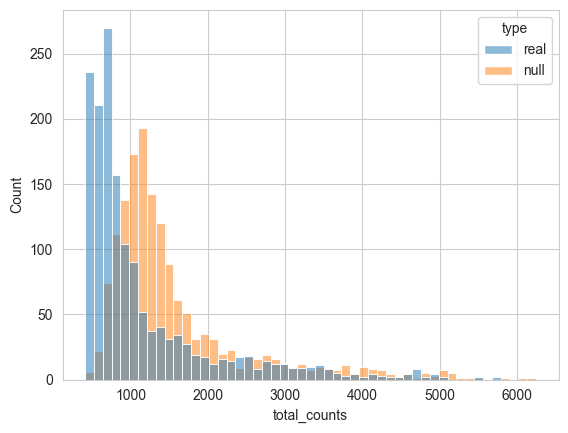

In [288]:
sns.histplot(cell_df, x="total_counts", hue="type")

In [289]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_counts = pd.DataFrame({"count_orig": data_gene_nonzero.layers["counts"].toarray().flatten(), "count_gen": data_null_gen.layers["counts"].flatten()})
count_pairs = all_counts.groupby(['count_orig','count_gen']).size().reset_index().rename(columns={0:'count'})
count_pairs["log_count"] = np.log(count_pairs["count"])
count_pairs = count_pairs.pivot(index="count_gen", columns="count_orig", values="log_count")
count_pairs


count_orig,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,99.0,100.0,101.0,102.0,103.0,104.0,107.0,114.0,129.0,136.0
count_gen,,,,,,,,,,,,,,,,,,,,,
0.0,15.692543,13.361837,11.672175,10.088638,8.978913,8.072467,7.407924,6.830874,6.406880,6.028279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,13.396948,11.976238,10.620595,9.345832,8.398860,7.667626,7.093405,6.565265,6.196444,5.805135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2.0,11.835321,10.833583,9.721666,8.674368,7.908755,7.280008,6.701960,6.378426,5.918894,5.480639,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3.0,10.465814,9.809452,8.899867,8.075583,7.441907,6.916715,6.418365,5.924256,5.616771,5.257495,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4.0,9.251866,8.924257,8.256867,7.596894,7.016610,6.439350,6.063785,5.669881,5.370638,5.049856,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
all_counts.reset_index()

,index,count_orig,count_gen
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,1.0
3,3,0.0,0.0
4,4,0.0,1.0
...,...,...,...
8563019,8563019,0.0,0.0
8563020,8563020,0.0,0.0
8563021,8563021,1.0,1.0
8563022,8563022,6.0,3.0


In [270]:
all_counts_long = pd.wide_to_long(all_counts.reset_index(), stubnames="count", i="index", j="type", sep="_", suffix=r'\w+').reset_index()
all_counts_long

,index,type,count
0,0,orig,0.0
1,1,orig,0.0
2,2,orig,0.0
3,3,orig,0.0
4,4,orig,0.0
...,...,...,...
17126043,8563019,gen,0.0
17126044,8563020,gen,0.0
17126045,8563021,gen,1.0
17126046,8563022,gen,3.0


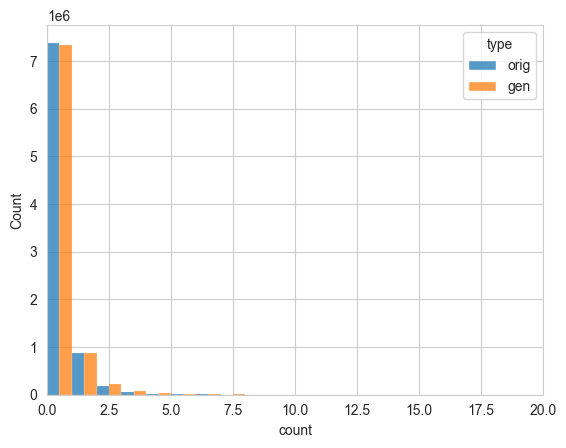

In [271]:
g = sns.histplot(all_counts_long, x="count", hue="type", binwidth=1, multiple="dodge")
g.set(xlim=(0, 20))
plt.show()